# Todo

## MAGIC dataset
* kNN
* LR(?)
* NN using tensorflow
* XGBoost
* PCA
* Rerun methods
* Write report comparing methods and discussing importance of PCA for ten features (19020 datapoints) where some have correlation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.neighbors as sklne
import sklearn.model_selection as sklms
import sklearn.preprocessing as sklpre
import tensorflow as tf
import seaborn as sns
import scikitplot as sklplt
import sklearn.metrics as sklme
import tensorflow_addons as tfa
import xgboost as xgb
import sklearn.decomposition as sklde
import skopt

fonts = {
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
}

plt.rcParams.update(fonts)

np.random.seed(123)

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# Black for Jupyter Notebook!
%load_ext nb_black

<IPython.core.display.Javascript object>

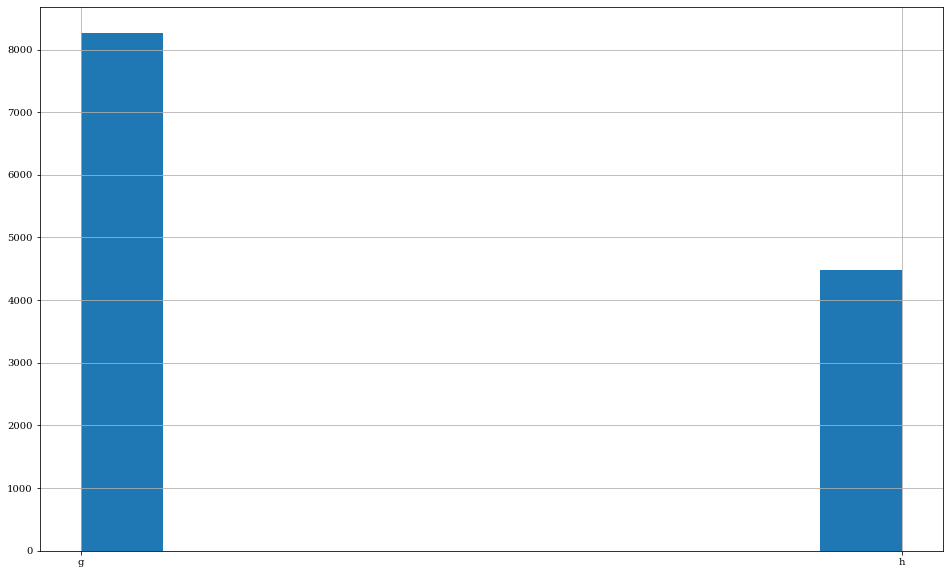

<IPython.core.display.Javascript object>

In [3]:
# Reading data
df = pd.read_csv("telescope_data.csv")
# Dropping useless column
df.drop("Unnamed: 0", axis=1, inplace=True)
# Setting feature matrix X and outcome y
X = df.drop("class", axis=1)
y = df["class"]

# Splitting
X_train, X_test, y_train, y_test = sklms.train_test_split(
    X, y, stratify=y, test_size=0.33
)

# Scaling feature matrix (All features are scalar).
scaler = sklpre.StandardScaler()

X_train = pd.DataFrame(
    scaler.fit_transform(X_train.to_numpy()), columns=X_train.columns
)
X_test = pd.DataFrame(scaler.transform(X_test.to_numpy()), columns=X_test.columns)

# One-hot encoding outcomes, keeping them as dataframes
encoder = sklpre.OneHotEncoder(categories="auto", sparse=False)
# Plotting histogram of outcomes
fig, ax = plt.subplots(figsize=(10 * 1.618, 10))
y_train.hist(ax=ax, density=False)

y_train = pd.DataFrame(
    encoder.fit_transform(y_train.to_numpy().reshape(-1, 1)),
    columns=encoder.categories_,
)
y_test = pd.DataFrame(
    encoder.fit_transform(y_test.to_numpy().reshape(-1, 1)),
    columns=encoder.categories_,
)

plt.show()
# Deleting non-used objects to avoid bugs later and save memory
del X
del y
del df

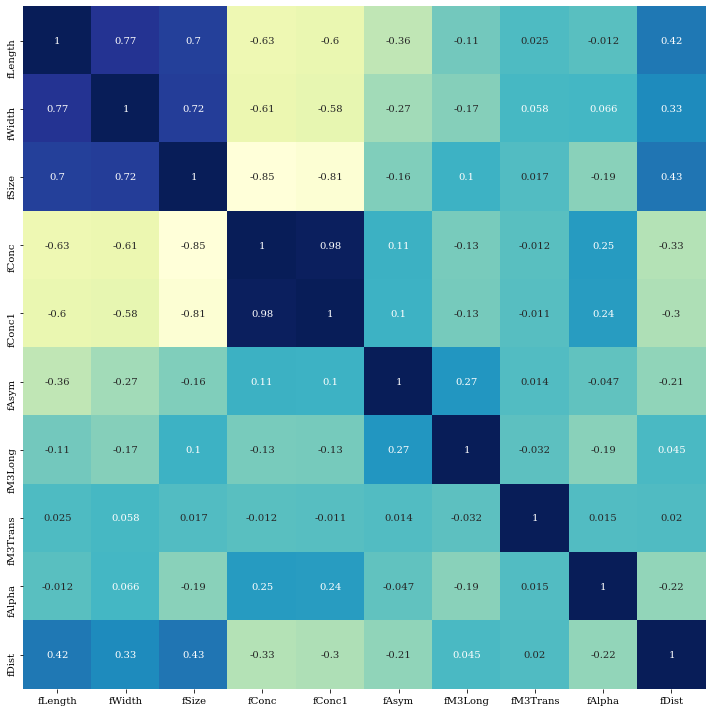

<IPython.core.display.Javascript object>

In [4]:
# Plotting correlation matrix
fig, ax = plt.subplots(figsize=(10 * 1.618, 10))
sns.heatmap(X_train.corr(), cmap="YlGnBu", ax=ax, square=True, annot=True, cbar=False)
ax.set_ylim([10, 0])
ax.set_xlim([0, 10])
fig.tight_layout()
plt.show()

# kNN

In [5]:
X_train_split, X_validation, y_train_split, y_validation = sklms.train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train
)
X_train_split = X_train_split.to_numpy()
X_validation = X_validation.to_numpy()

y_train_split = y_train_split.to_numpy()

y_validation = y_validation.to_numpy()

<IPython.core.display.Javascript object>

k-NN:
Train weighted f1 score: 0.88
Test weighted f1 score: 0.83
Best k = 5


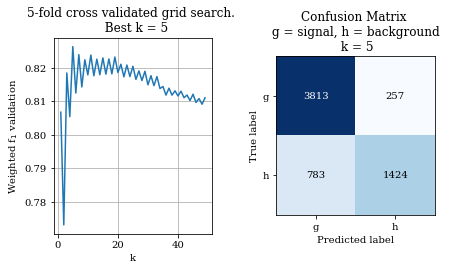

<IPython.core.display.Javascript object>

In [6]:
best_hyperparams = np.load("models/best_hyperparams_nn.npy")
best_batch_nn = best_hyperparams[0]
best_dropout_1 = best_hyperparams[1]
best_dropout_2 = best_hyperparams[2]
best_nodes_1 = best_hyperparams[3]
best_nodes_2 = best_hyperparams[4]

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(best_nodes_1, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_1),
        tf.keras.layers.Dense(best_nodes_2, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_2),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam", loss="categorical_crossentropy",
)
model.load_weights("models/best_nn_not_pca")

y_pred_train_nn = model.predict_classes(X_train.to_numpy()).reshape(-1, 1)
y_pred_train_nn = np.append(y_pred_train_nn == 0, y_pred_train_nn == 1, axis=1).astype(
    np.int
)

y_pred_test_nn = model.predict_classes(X_test.to_numpy()).reshape(-1, 1)
y_pred_test_nn = np.append(y_pred_test_nn == 0, y_pred_test_nn == 1, axis=1).astype(
    np.int
)

f1_score_weighted_train = sklme.f1_score(
    y_true=y_train, y_pred=y_pred_train_nn, average="weighted"
)

f1_score_weighted_test = sklme.f1_score(
    y_true=y_test, y_pred=y_pred_test_nn, average="weighted"
)


print("Neural Network:")
print(f"Train weighted f1 score: {f1_score_weighted_train:.2f}")
print(f"Test weighted f1 score: {f1_score_weighted_test:.2f}")
print(f"Best hyperparams: {optimizer_nn['x']}")

fig, ax = plt.subplots(figsize=[3.01682, 3.01682])
sklplt.metrics.plot_confusion_matrix(
    encoder.inverse_transform(y_test.to_numpy()),
    encoder.inverse_transform(y_pred_test_nn),
    ax=ax,
)
ax.set_ylim([1.5, -0.5])
ax.set_xlim([-0.5, 1.5])
im = ax.images
cb = im[-1].colorbar
cb.remove()
fig.tight_layout()
fig.savefig("doc/figures/nn_confusion_matrix.pdf", dpi=1000)
plt.show()

# Tensorflow neural network
## Setting hyperparameters based on validation f1

In [5]:
X_train_split, X_validation, y_train_split, y_validation = sklms.train_test_split(
    X_train, y_train, test_size=0.1, stratify=y_train
)
X_train_split = X_train_split.to_numpy()
X_validation = X_validation.to_numpy()

y_train_split = y_train_split.to_numpy()

y_validation = y_validation.to_numpy()

<IPython.core.display.Javascript object>

In [14]:
batch_sizes = skopt.space.Integer(low=1, high=200, name="batch_size")
dropout_1 = skopt.space.Real(low=0, high=0.5, name="dropout_1")
dropout_2 = skopt.space.Real(low=0, high=0.5, name="dropout_2")
nodes_1 = skopt.space.Integer(low=1, high=20, name="nodes_1")
nodes_2 = skopt.space.Integer(low=1, high=10, name="nodes_2")
space = [batch_sizes, dropout_1, dropout_2, nodes_1, nodes_2]


@skopt.utils.use_named_args(dimensions=space)
def neural_network_fit(
    batch_size, dropout_1, dropout_2, nodes_1, nodes_2, return_epochs=False
):
    early_stop = callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, verbose=1, restore_best_weights=True
    )
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Dense(nodes_1, activation="relu"),
            tf.keras.layers.Dropout(dropout_1),
            tf.keras.layers.Dense(nodes_2, activation="relu"),
            tf.keras.layers.Dropout(dropout_2),
            tf.keras.layers.Dense(2, activation="softmax"),
        ]
    )
    model.compile(
        optimizer="adam", loss="categorical_crossentropy",
    )

    model.fit(
        X_train_split,
        y_train_split,
        epochs=100,
        batch_size=batch_size,
        validation_data=(X_validation, y_validation),
        verbose=0,
        callbacks=[early_stop],
    )
    if return_epochs:
        print("jeff")
        return early_stop.stopped_epoch
    y_pred_validation_nn = model.predict_classes(X_validation).reshape(-1, 1)
    y_pred_validation_nn = np.append(
        y_pred_validation_nn == 0, y_pred_validation_nn == 1, axis=1
    ).astype(np.int)
    f1_score_weighted_validation = sklme.f1_score(
        y_true=y_validation, y_pred=y_pred_validation_nn, average="weighted"
    )

    return 1 - f1_score_weighted_validation


n_points = 1000
optimizer_nn = skopt.gp_minimize(
    func=neural_network_fit,
    dimensions=space,
    n_jobs=-1,
    verbose=True,
    n_calls=n_points,
    n_random_starts=n_points,
)

Iteration No: 1 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 11.1658
Function value obtained: 0.1574
Current minimum: 0.1574
Iteration No: 2 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.7843
Function value obtained: 0.1759
Current minimum: 0.1574
Iteration No: 3 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 27.9418
Function value obtained: 0.1639
Current minimum: 0.1574
Iteration No: 4 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Iteration No: 4 ended

Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
Iteration No: 23 ended. Evaluation done at random point.
Time taken: 9.0273
Function value obtained: 0.1515
Current minimum: 0.1382
Iteration No: 24 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
Iteration No: 24 ended. Evaluation done at random point.
Time taken: 10.3372
Function value obtained: 0.1409
Current minimum: 0.1382
Iteration No: 25 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
Iteration No: 25 ended. Evaluation done at random point.
Time taken: 3.2369
Function value obtained: 0.2164
Current minimum: 0.1382
Iteration No: 26 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Iteration No: 26 ended. Evaluation done at random point.
Time taken: 14.9112
F

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
Iteration No: 32 ended. Evaluation done at random point.
Time taken: 8.6208
Function value obtained: 0.1465
Current minimum: 0.1382
Iteration No: 33 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
Iteration No: 33 ended. Evaluation done at random point.
Time taken: 11.7113
Function value obtained: 0.1566
Current minimum: 0.1382
Iteration No: 34 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Iteration No: 34 ended. Evaluation done at random point.
Time taken: 15.8523
Function value obtained: 0.1499
Current minimum: 0.1382
Iteration No: 35 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
Iteration No: 35 ended. Evaluation done at random point.
Time taken: 14.6483


/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
Iteration No: 41 ended. Evaluation done at random point.
Time taken: 25.1706
Function value obtained: 0.1735
Current minimum: 0.1382
Iteration No: 42 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Iteration No: 42 ended. Evaluation done at random point.
Time taken: 7.5199
Function value obtained: 0.2168
Current minimum: 0.1382
Iteration No: 43 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
Iteration No: 43 ended. Evaluation done at random point.
Time taken: 8.9384
Function value obtained: 0.1710
Current minimum: 0.1382
Iteration No: 44 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Iteration No: 44 ended. Evaluation done at random point.
Time taken: 20.2169
F

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00062: early stopping
Iteration No: 52 ended. Evaluation done at random point.
Time taken: 8.3233
Function value obtained: 0.1488
Current minimum: 0.1382
Iteration No: 53 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Iteration No: 53 ended. Evaluation done at random point.
Time taken: 8.0724
Function value obtained: 0.1601
Current minimum: 0.1382
Iteration No: 54 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Iteration No: 54 ended. Evaluation done at random point.
Time taken: 6.4971
Function value obtained: 0.1952
Current minimum: 0.1382
Iteration No: 55 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Iteration No: 55 ended. Evaluation done at random point.
Time taken: 8.5723
Fun

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Iteration No: 82 ended. Evaluation done at random point.
Time taken: 7.7783
Function value obtained: 0.1582
Current minimum: 0.1382
Iteration No: 83 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
Iteration No: 83 ended. Evaluation done at random point.
Time taken: 7.8282
Function value obtained: 0.2094
Current minimum: 0.1382
Iteration No: 84 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Iteration No: 84 ended. Evaluation done at random point.
Time taken: 12.7786
Function value obtained: 0.1504
Current minimum: 0.1382
Iteration No: 85 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Iteration No: 85 ended. Evaluation done at random point.
Time taken: 10.3108
F

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Iteration No: 112 ended. Evaluation done at random point.
Time taken: 10.1897
Function value obtained: 0.1483
Current minimum: 0.1382
Iteration No: 113 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Iteration No: 113 ended. Evaluation done at random point.
Time taken: 12.5578
Function value obtained: 0.1355
Current minimum: 0.1355
Iteration No: 114 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Iteration No: 114 ended. Evaluation done at random point.
Time taken: 5.4743
Function value obtained: 0.2215
Current minimum: 0.1355
Iteration No: 115 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Iteration No: 115 ended. Evaluation done at random point.
Time taken: 4

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Iteration No: 119 ended. Evaluation done at random point.
Time taken: 10.9078
Function value obtained: 0.1678
Current minimum: 0.1355
Iteration No: 120 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Iteration No: 120 ended. Evaluation done at random point.
Time taken: 12.4267
Function value obtained: 0.1409
Current minimum: 0.1355
Iteration No: 121 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Iteration No: 121 ended. Evaluation done at random point.
Time taken: 6.4038
Function value obtained: 0.2158
Current minimum: 0.1355
Iteration No: 122 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Iteration No: 122 ended. Evaluation done at random point.
Time taken: 6

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Iteration No: 149 ended. Evaluation done at random point.
Time taken: 6.7184
Function value obtained: 0.1514
Current minimum: 0.1355
Iteration No: 150 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Iteration No: 150 ended. Evaluation done at random point.
Time taken: 5.7232
Function value obtained: 0.1654
Current minimum: 0.1355
Iteration No: 151 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
Iteration No: 151 ended. Evaluation done at random point.
Time taken: 34.0263
Function value obtained: 0.1391
Current minimum: 0.1355
Iteration No: 152 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Iteration No: 152 ended. Evaluation done at random point.
Time taken: 6.

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Iteration No: 179 ended. Evaluation done at random point.
Time taken: 10.2093
Function value obtained: 0.1576
Current minimum: 0.1355
Iteration No: 180 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Iteration No: 180 ended. Evaluation done at random point.
Time taken: 8.6020
Function value obtained: 0.2348
Current minimum: 0.1355
Iteration No: 181 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Iteration No: 181 ended. Evaluation done at random point.
Time taken: 11.5991
Function value obtained: 0.1422
Current minimum: 0.1355
Iteration No: 182 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Iteration No: 182 ended. Evaluation done at random point.
Time taken: 2

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
Iteration No: 209 ended. Evaluation done at random point.
Time taken: 181.3615
Function value obtained: 0.1453
Current minimum: 0.1355
Iteration No: 210 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
Iteration No: 210 ended. Evaluation done at random point.
Time taken: 9.5771
Function value obtained: 0.1338
Current minimum: 0.1338
Iteration No: 211 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Iteration No: 211 ended. Evaluation done at random point.
Time taken: 4.6382
Function value obtained: 0.2194
Current minimum: 0.1338
Iteration No: 212 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
Iteration No: 212 ended. Evaluation done at random point.
Time taken: 5

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping
Iteration No: 236 ended. Evaluation done at random point.
Time taken: 10.9298
Function value obtained: 0.1490
Current minimum: 0.1338
Iteration No: 237 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
Iteration No: 237 ended. Evaluation done at random point.
Time taken: 8.6316
Function value obtained: 0.1566
Current minimum: 0.1338
Iteration No: 238 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
Iteration No: 238 ended. Evaluation done at random point.
Time taken: 7.1217
Function value obtained: 0.2008
Current minimum: 0.1338
Iteration No: 239 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Iteration No: 239 ended. Evaluation done at random point.
Time taken: 5.

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Iteration No: 266 ended. Evaluation done at random point.
Time taken: 4.5575
Function value obtained: 0.2210
Current minimum: 0.1338
Iteration No: 267 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
Iteration No: 267 ended. Evaluation done at random point.
Time taken: 6.5868
Function value obtained: 0.1706
Current minimum: 0.1338
Iteration No: 268 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Iteration No: 268 ended. Evaluation done at random point.
Time taken: 9.3509
Function value obtained: 0.1485
Current minimum: 0.1338
Iteration No: 269 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
Iteration No: 269 ended. Evaluation done at random point.
Time taken: 21.

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Iteration No: 296 ended. Evaluation done at random point.
Time taken: 8.6252
Function value obtained: 0.1988
Current minimum: 0.1338
Iteration No: 297 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Iteration No: 297 ended. Evaluation done at random point.
Time taken: 7.3764
Function value obtained: 0.2522
Current minimum: 0.1338
Iteration No: 298 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Iteration No: 298 ended. Evaluation done at random point.
Time taken: 6.6932
Function value obtained: 0.1610
Current minimum: 0.1338
Iteration No: 299 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping
Iteration No: 299 ended. Evaluation done at random point.
Time taken: 13.

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Iteration No: 300 ended. Evaluation done at random point.
Time taken: 29.5385
Function value obtained: 0.1446
Current minimum: 0.1338
Iteration No: 301 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping
Iteration No: 301 ended. Evaluation done at random point.
Time taken: 69.9531
Function value obtained: 0.1539
Current minimum: 0.1338
Iteration No: 302 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Iteration No: 302 ended. Evaluation done at random point.
Time taken: 13.6729
Function value obtained: 0.1400
Current minimum: 0.1338
Iteration No: 303 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
Iteration No: 303 ended. Evaluation done at random point.
Time taken: 

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Iteration No: 330 ended. Evaluation done at random point.
Time taken: 46.7248
Function value obtained: 0.1478
Current minimum: 0.1338
Iteration No: 331 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Iteration No: 331 ended. Evaluation done at random point.
Time taken: 5.8517
Function value obtained: 0.1444
Current minimum: 0.1338
Iteration No: 332 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Iteration No: 332 ended. Evaluation done at random point.
Time taken: 4.2066
Function value obtained: 0.2273
Current minimum: 0.1338
Iteration No: 333 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Iteration No: 333 ended. Evaluation done at random point.
Time taken: 12

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Iteration No: 360 ended. Evaluation done at random point.
Time taken: 13.6474
Function value obtained: 0.1609
Current minimum: 0.1338
Iteration No: 361 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Iteration No: 361 ended. Evaluation done at random point.
Time taken: 47.3314
Function value obtained: 0.1433
Current minimum: 0.1338
Iteration No: 362 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Iteration No: 362 ended. Evaluation done at random point.
Time taken: 6.0826
Function value obtained: 0.1677
Current minimum: 0.1338
Iteration No: 363 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
Iteration No: 363 ended. Evaluation done at random point.
Time taken: 1

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
Iteration No: 383 ended. Evaluation done at random point.
Time taken: 33.4477
Function value obtained: 0.1515
Current minimum: 0.1338
Iteration No: 384 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Iteration No: 384 ended. Evaluation done at random point.
Time taken: 10.1722
Function value obtained: 0.2315
Current minimum: 0.1338
Iteration No: 385 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Iteration No: 385 ended. Evaluation done at random point.
Time taken: 6.9598
Function value obtained: 0.1534
Current minimum: 0.1338
Iteration No: 386 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Iteration No: 386 ended. Evaluation done at random point.
Time taken: 1

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
Iteration No: 413 ended. Evaluation done at random point.
Time taken: 8.5846
Function value obtained: 0.1450
Current minimum: 0.1338
Iteration No: 414 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
Iteration No: 414 ended. Evaluation done at random point.
Time taken: 8.6773
Function value obtained: 0.1548
Current minimum: 0.1338
Iteration No: 415 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Iteration No: 415 ended. Evaluation done at random point.
Time taken: 4.8487
Function value obtained: 0.1554
Current minimum: 0.1338
Iteration No: 416 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Iteration No: 416 ended. Evaluation done at random point.
Time taken: 6.2

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Iteration No: 420 ended. Evaluation done at random point.
Time taken: 6.3090
Function value obtained: 0.2380
Current minimum: 0.1338
Iteration No: 421 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Iteration No: 421 ended. Evaluation done at random point.
Time taken: 7.6350
Function value obtained: 0.2227
Current minimum: 0.1338
Iteration No: 422 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00020: early stopping
Iteration No: 422 ended. Evaluation done at random point.
Time taken: 25.1452
Function value obtained: 0.1324
Current minimum: 0.1324
Iteration No: 423 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
Iteration No: 423 ended. Evaluation done at random point.
Time taken: 9.

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Iteration No: 425 ended. Evaluation done at random point.
Time taken: 17.1566
Function value obtained: 0.1544
Current minimum: 0.1324
Iteration No: 426 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping
Iteration No: 426 ended. Evaluation done at random point.
Time taken: 9.1365
Function value obtained: 0.1385
Current minimum: 0.1324
Iteration No: 427 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
Iteration No: 427 ended. Evaluation done at random point.
Time taken: 6.7554
Function value obtained: 0.1627
Current minimum: 0.1324
Iteration No: 428 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Iteration No: 428 ended. Evaluation done at random point.
Time taken: 7.

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Iteration No: 430 ended. Evaluation done at random point.
Time taken: 11.1594
Function value obtained: 0.1579
Current minimum: 0.1324
Iteration No: 431 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
Iteration No: 431 ended. Evaluation done at random point.
Time taken: 9.3364
Function value obtained: 0.1598
Current minimum: 0.1324
Iteration No: 432 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping
Iteration No: 432 ended. Evaluation done at random point.
Time taken: 7.6351
Function value obtained: 0.1448
Current minimum: 0.1324
Iteration No: 433 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
Iteration No: 433 ended. Evaluation done at random point.
Time taken: 5.

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Iteration No: 446 ended. Evaluation done at random point.
Time taken: 4.7306
Function value obtained: 0.2197
Current minimum: 0.1324
Iteration No: 447 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Iteration No: 447 ended. Evaluation done at random point.
Time taken: 25.1728
Function value obtained: 0.1505
Current minimum: 0.1324
Iteration No: 448 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Iteration No: 448 ended. Evaluation done at random point.
Time taken: 7.9308
Function value obtained: 0.1830
Current minimum: 0.1324
Iteration No: 449 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
Iteration No: 449 ended. Evaluation done at random point.
Time taken: 37

Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping
Iteration No: 476 ended. Evaluation done at random point.
Time taken: 15.8804
Function value obtained: 0.1841
Current minimum: 0.1324
Iteration No: 477 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Iteration No: 477 ended. Evaluation done at random point.
Time taken: 7.1092
Function value obtained: 0.1408
Current minimum: 0.1324
Iteration No: 478 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Iteration No: 478 ended. Evaluation done at random point.
Time taken: 4.0112
Function value obtained: 0.1983
Current minimum: 0.1324
Iteration No: 479 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Iteration No: 479 ended. Evaluation done at random point.
Time taken: 11

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Iteration No: 487 ended. Evaluation done at random point.
Time taken: 10.5407
Function value obtained: 0.1685
Current minimum: 0.1324
Iteration No: 488 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
Iteration No: 488 ended. Evaluation done at random point.
Time taken: 10.1788
Function value obtained: 0.1518
Current minimum: 0.1324
Iteration No: 489 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Iteration No: 489 ended. Evaluation done at random point.
Time taken: 10.1372
Function value obtained: 0.1508
Current minimum: 0.1324
Iteration No: 490 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Iteration No: 490 ended. Evaluation done at random point.
Time taken: 

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00057: early stopping
Iteration No: 492 ended. Evaluation done at random point.
Time taken: 9.2368
Function value obtained: 0.1554
Current minimum: 0.1322
Iteration No: 493 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Iteration No: 493 ended. Evaluation done at random point.
Time taken: 4.0822
Function value obtained: 0.1829
Current minimum: 0.1322
Iteration No: 494 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Iteration No: 494 ended. Evaluation done at random point.
Time taken: 17.7395
Function value obtained: 0.1450
Current minimum: 0.1322
Iteration No: 495 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Iteration No: 495 ended. Evaluation done at random point.
Time taken: 4.

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
Iteration No: 504 ended. Evaluation done at random point.
Time taken: 7.4356
Function value obtained: 0.1431
Current minimum: 0.1322
Iteration No: 505 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
Iteration No: 505 ended. Evaluation done at random point.
Time taken: 11.4240
Function value obtained: 0.1483
Current minimum: 0.1322
Iteration No: 506 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Iteration No: 506 ended. Evaluation done at random point.
Time taken: 9.0634
Function value obtained: 0.1673
Current minimum: 0.1322
Iteration No: 507 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Iteration No: 507 ended. Evaluation done at random point.
Time taken: 4.

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Iteration No: 534 ended. Evaluation done at random point.
Time taken: 8.5326
Function value obtained: 0.1454
Current minimum: 0.1322
Iteration No: 535 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Iteration No: 535 ended. Evaluation done at random point.
Time taken: 7.5742
Function value obtained: 0.1543
Current minimum: 0.1322
Iteration No: 536 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Iteration No: 536 ended. Evaluation done at random point.
Time taken: 14.7453
Function value obtained: 0.1372
Current minimum: 0.1322
Iteration No: 537 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
Iteration No: 537 ended. Evaluation done at random point.
Time taken: 7.

Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
Iteration No: 564 ended. Evaluation done at random point.
Time taken: 8.5219
Function value obtained: 0.1451
Current minimum: 0.1322
Iteration No: 565 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Iteration No: 565 ended. Evaluation done at random point.
Time taken: 7.4622
Function value obtained: 0.1619
Current minimum: 0.1322
Iteration No: 566 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
Iteration No: 566 ended. Evaluation done at random point.
Time taken: 13.1823
Function value obtained: 0.1544
Current minimum: 0.1322
Iteration No: 567 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Iteration No: 567 ended. Evaluation done at random point.
Time taken: 5.

Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping
Iteration No: 594 ended. Evaluation done at random point.
Time taken: 13.7409
Function value obtained: 0.1575
Current minimum: 0.1322
Iteration No: 595 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Iteration No: 595 ended. Evaluation done at random point.
Time taken: 6.2633
Function value obtained: 0.1498
Current minimum: 0.1322
Iteration No: 596 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Iteration No: 596 ended. Evaluation done at random point.
Time taken: 21.1350
Function value obtained: 0.1566
Current minimum: 0.1322
Iteration No: 597 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Iteration No: 597 ended. Evaluation done at random point.
Time taken: 1

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Iteration No: 605 ended. Evaluation done at random point.
Time taken: 8.3504
Function value obtained: 0.1735
Current minimum: 0.1322
Iteration No: 606 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00064: early stopping
Iteration No: 606 ended. Evaluation done at random point.
Time taken: 7.9839
Function value obtained: 0.1498
Current minimum: 0.1322
Iteration No: 607 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Iteration No: 607 ended. Evaluation done at random point.
Time taken: 10.0721
Function value obtained: 0.1728
Current minimum: 0.1322
Iteration No: 608 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Iteration No: 608 ended. Evaluation done at random point.
Time taken: 10

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Iteration No: 634 ended. Evaluation done at random point.
Time taken: 8.9391
Function value obtained: 0.1710
Current minimum: 0.1322
Iteration No: 635 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Iteration No: 635 ended. Evaluation done at random point.
Time taken: 14.8593
Function value obtained: 0.1600
Current minimum: 0.1322
Iteration No: 636 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Iteration No: 636 ended. Evaluation done at random point.
Time taken: 7.7855
Function value obtained: 0.1470
Current minimum: 0.1322
Iteration No: 637 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Iteration No: 637 ended. Evaluation done at random point.
Time taken: 9.

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Iteration No: 646 ended. Evaluation done at random point.
Time taken: 14.1859
Function value obtained: 0.1438
Current minimum: 0.1322
Iteration No: 647 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Iteration No: 647 ended. Evaluation done at random point.
Time taken: 9.1490
Function value obtained: 0.1578
Current minimum: 0.1322
Iteration No: 648 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Iteration No: 648 ended. Evaluation done at random point.
Time taken: 6.8388
Function value obtained: 0.1883
Current minimum: 0.1322
Iteration No: 649 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
Iteration No: 649 ended. Evaluation done at random point.
Time taken: 7.

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
Iteration No: 655 ended. Evaluation done at random point.
Time taken: 11.5826
Function value obtained: 0.1445
Current minimum: 0.1322
Iteration No: 656 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Iteration No: 656 ended. Evaluation done at random point.
Time taken: 13.2759
Function value obtained: 0.1447
Current minimum: 0.1322
Iteration No: 657 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
Iteration No: 657 ended. Evaluation done at random point.
Time taken: 7.7527
Function value obtained: 0.2041
Current minimum: 0.1322
Iteration No: 658 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Iteration No: 658 ended. Evaluation done at random point.
Time taken: 4

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Iteration No: 671 ended. Evaluation done at random point.
Time taken: 185.5152
Function value obtained: 0.1402
Current minimum: 0.1322
Iteration No: 672 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Iteration No: 672 ended. Evaluation done at random point.
Time taken: 20.3179
Function value obtained: 0.1474
Current minimum: 0.1322
Iteration No: 673 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
Iteration No: 673 ended. Evaluation done at random point.
Time taken: 8.6061
Function value obtained: 0.1558
Current minimum: 0.1322
Iteration No: 674 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Iteration No: 674 ended. Evaluation done at random point.
Time taken: 

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Iteration No: 701 ended. Evaluation done at random point.
Time taken: 6.8422
Function value obtained: 0.1520
Current minimum: 0.1322
Iteration No: 702 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Iteration No: 702 ended. Evaluation done at random point.
Time taken: 33.8375
Function value obtained: 0.1536
Current minimum: 0.1322
Iteration No: 703 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
Iteration No: 703 ended. Evaluation done at random point.
Time taken: 27.9184
Function value obtained: 0.1589
Current minimum: 0.1322
Iteration No: 704 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00060: early stopping
Iteration No: 704 ended. Evaluation done at random point.
Time taken: 1

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Iteration No: 709 ended. Evaluation done at random point.
Time taken: 8.9898
Function value obtained: 0.1488
Current minimum: 0.1322
Iteration No: 710 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00073: early stopping
Iteration No: 710 ended. Evaluation done at random point.
Time taken: 10.5880
Function value obtained: 0.1462
Current minimum: 0.1322
Iteration No: 711 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Iteration No: 711 ended. Evaluation done at random point.
Time taken: 21.3534
Function value obtained: 0.1581
Current minimum: 0.1322
Iteration No: 712 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00056: early stopping
Iteration No: 712 ended. Evaluation done at random point.
Time taken: 1

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Iteration No: 730 ended. Evaluation done at random point.
Time taken: 6.4559
Function value obtained: 0.1522
Current minimum: 0.1322
Iteration No: 731 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Iteration No: 731 ended. Evaluation done at random point.
Time taken: 4.5701
Function value obtained: 0.1677
Current minimum: 0.1322
Iteration No: 732 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Iteration No: 732 ended. Evaluation done at random point.
Time taken: 22.8347
Function value obtained: 0.1558
Current minimum: 0.1322
Iteration No: 733 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
Iteration No: 733 ended. Evaluation done at random point.
Time taken: 19

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Iteration No: 755 ended. Evaluation done at random point.
Time taken: 10.0894
Function value obtained: 0.1834
Current minimum: 0.1322
Iteration No: 756 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Iteration No: 756 ended. Evaluation done at random point.
Time taken: 3.1066
Function value obtained: 0.2558
Current minimum: 0.1322
Iteration No: 757 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Iteration No: 757 ended. Evaluation done at random point.
Time taken: 7.7937
Function value obtained: 0.1545
Current minimum: 0.1322
Iteration No: 758 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00065: early stopping
Iteration No: 758 ended. Evaluation done at random point.
Time taken: 7.

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Iteration No: 775 ended. Evaluation done at random point.
Time taken: 24.2691
Function value obtained: 0.1582
Current minimum: 0.1322
Iteration No: 776 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00053: early stopping
Iteration No: 776 ended. Evaluation done at random point.
Time taken: 7.9475
Function value obtained: 0.1467
Current minimum: 0.1322
Iteration No: 777 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00074: early stopping
Iteration No: 777 ended. Evaluation done at random point.
Time taken: 10.5444
Function value obtained: 0.1468
Current minimum: 0.1322
Iteration No: 778 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
Iteration No: 778 ended. Evaluation done at random point.
Time taken: 7

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Iteration No: 800 ended. Evaluation done at random point.
Time taken: 6.9450
Function value obtained: 0.1709
Current minimum: 0.1322
Iteration No: 801 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00055: early stopping
Iteration No: 801 ended. Evaluation done at random point.
Time taken: 6.9830
Function value obtained: 0.1480
Current minimum: 0.1322
Iteration No: 802 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Iteration No: 802 ended. Evaluation done at random point.
Time taken: 10.9856
Function value obtained: 0.1463
Current minimum: 0.1322
Iteration No: 803 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Iteration No: 803 ended. Evaluation done at random point.
Time taken: 8.

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Iteration No: 817 ended. Evaluation done at random point.
Time taken: 19.6638
Function value obtained: 0.1538
Current minimum: 0.1322
Iteration No: 818 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Iteration No: 818 ended. Evaluation done at random point.
Time taken: 6.3987
Function value obtained: 0.1469
Current minimum: 0.1322
Iteration No: 819 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Iteration No: 819 ended. Evaluation done at random point.
Time taken: 15.2980
Function value obtained: 0.1417
Current minimum: 0.1322
Iteration No: 820 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Iteration No: 820 ended. Evaluation done at random point.
Time taken: 1

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00067: early stopping
Iteration No: 823 ended. Evaluation done at random point.
Time taken: 11.3243
Function value obtained: 0.1485
Current minimum: 0.1322
Iteration No: 824 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Iteration No: 824 ended. Evaluation done at random point.
Time taken: 4.1627
Function value obtained: 0.2279
Current minimum: 0.1322
Iteration No: 825 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00054: early stopping
Iteration No: 825 ended. Evaluation done at random point.
Time taken: 8.3964
Function value obtained: 0.1622
Current minimum: 0.1322
Iteration No: 826 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Iteration No: 826 ended. Evaluation done at random point.
Time taken: 18

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Iteration No: 829 ended. Evaluation done at random point.
Time taken: 7.0356
Function value obtained: 0.1488
Current minimum: 0.1322
Iteration No: 830 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Iteration No: 830 ended. Evaluation done at random point.
Time taken: 15.6870
Function value obtained: 0.1979
Current minimum: 0.1322
Iteration No: 831 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00061: early stopping
Iteration No: 831 ended. Evaluation done at random point.
Time taken: 7.7560
Function value obtained: 0.1587
Current minimum: 0.1322
Iteration No: 832 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Iteration No: 832 ended. Evaluation done at random point.
Time taken: 30

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Iteration No: 858 ended. Evaluation done at random point.
Time taken: 20.2852
Function value obtained: 0.1575
Current minimum: 0.1286
Iteration No: 859 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
Iteration No: 859 ended. Evaluation done at random point.
Time taken: 33.7092
Function value obtained: 0.1409
Current minimum: 0.1286
Iteration No: 860 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Iteration No: 860 ended. Evaluation done at random point.
Time taken: 8.3157
Function value obtained: 0.1631
Current minimum: 0.1286
Iteration No: 861 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Iteration No: 861 ended. Evaluation done at random point.
Time taken: 7

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
Iteration No: 879 ended. Evaluation done at random point.
Time taken: 8.5819
Function value obtained: 0.1535
Current minimum: 0.1286
Iteration No: 880 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Iteration No: 880 ended. Evaluation done at random point.
Time taken: 14.6189
Function value obtained: 0.1631
Current minimum: 0.1286
Iteration No: 881 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Iteration No: 881 ended. Evaluation done at random point.
Time taken: 9.0387
Function value obtained: 0.1583
Current minimum: 0.1286
Iteration No: 882 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
Iteration No: 882 ended. Evaluation done at random point.
Time taken: 46

Restoring model weights from the end of the best epoch.
Epoch 00071: early stopping
Iteration No: 909 ended. Evaluation done at random point.
Time taken: 8.9072
Function value obtained: 0.1588
Current minimum: 0.1286
Iteration No: 910 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Iteration No: 910 ended. Evaluation done at random point.
Time taken: 7.8634
Function value obtained: 0.1620
Current minimum: 0.1286
Iteration No: 911 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00079: early stopping
Iteration No: 911 ended. Evaluation done at random point.
Time taken: 9.1903
Function value obtained: 0.1548
Current minimum: 0.1286
Iteration No: 912 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Iteration No: 912 ended. Evaluation done at random point.
Time taken: 12.

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Iteration No: 939 ended. Evaluation done at random point.
Time taken: 9.7839
Function value obtained: 0.2053
Current minimum: 0.1286
Iteration No: 940 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00059: early stopping
Iteration No: 940 ended. Evaluation done at random point.
Time taken: 9.2832
Function value obtained: 0.1464
Current minimum: 0.1286
Iteration No: 941 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Iteration No: 941 ended. Evaluation done at random point.
Time taken: 20.1238
Function value obtained: 0.1409
Current minimum: 0.1286
Iteration No: 942 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Iteration No: 942 ended. Evaluation done at random point.
Time taken: 6.

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping
Iteration No: 946 ended. Evaluation done at random point.
Time taken: 8.7807
Function value obtained: 0.1415
Current minimum: 0.1286
Iteration No: 947 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Iteration No: 947 ended. Evaluation done at random point.
Time taken: 8.7057
Function value obtained: 0.1442
Current minimum: 0.1286
Iteration No: 948 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00051: early stopping
Iteration No: 948 ended. Evaluation done at random point.
Time taken: 7.4263
Function value obtained: 0.1418
Current minimum: 0.1286
Iteration No: 949 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Iteration No: 949 ended. Evaluation done at random point.
Time taken: 8.5

/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
Iteration No: 970 ended. Evaluation done at random point.
Time taken: 9.1053
Function value obtained: 0.1588
Current minimum: 0.1286
Iteration No: 971 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Iteration No: 971 ended. Evaluation done at random point.
Time taken: 4.9220
Function value obtained: 0.2194
Current minimum: 0.1286
Iteration No: 972 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Iteration No: 972 ended. Evaluation done at random point.
Time taken: 11.5461
Function value obtained: 0.1562
Current minimum: 0.1286
Iteration No: 973 started. Evaluating function at random point.
Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Iteration No: 973 ended. Evaluation done at random point.
Time taken: 15

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping


/home/bernhard/.local/share/virtualenvs/FYS-STK4155-project3--QtDm4eX/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration No: 1000 ended. Evaluation done at random point.
Time taken: 96.7211
Function value obtained: 0.4896
Current minimum: 0.1286


<IPython.core.display.Javascript object>

## Refitting on full training set

In [16]:
best_batch_nn = optimizer_nn["x"][0]
best_dropout_1 = optimizer_nn["x"][1]
best_dropout_2 = optimizer_nn["x"][2]
best_nodes_1 = optimizer_nn["x"][3]
best_nodes_2 = optimizer_nn["x"][4]
print(
    type(best_batch_nn),
    type(best_dropout_1),
    best_dropout_2,
    type(best_nodes_1),
    best_nodes_2,
)
best_epochs = neural_network_fit.__wrapped__(
    best_batch_nn, best_dropout_1, best_dropout_2, best_nodes_1, best_nodes_2, True,
)
print(best_epochs)
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(best_nodes_1, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_1),
        tf.keras.layers.Dense(best_nodes_2, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_2),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam", loss="categorical_crossentropy",
)

model.fit(
    X_train.to_numpy(),
    y_train.to_numpy(),
    epochs=best_epochs,
    batch_size=best_batch_nn,
    verbose=1,
)
model.save_weights("models/best_nn_not_pca")
np.save("models/best_hyperparams_nn.npy", optimizer_nn["x"])

<class 'numpy.int64'> <class 'numpy.float64'> 0.32488036803798165 <class 'numpy.int64'> 5
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
jeff
43
Train on 12743 samples
Epoch 1/43
12743/12743 [==============================] - 1s 45us/sample - loss: 0.6939
Epoch 2/43
12743/12743 [==============================] - 0s 9us/sample - loss: 0.5707
Epoch 3/43
12743/12743 [==============================] - 0s 8us/sample - loss: 0.5239
Epoch 4/43
12743/12743 [==============================] - 0s 8us/sample - loss: 0.4978
Epoch 5/43
12743/12743 [==============================] - 0s 8us/sample - loss: 0.4846
Epoch 6/43
12743/12743 [==============================] - 0s 8us/sample - loss: 0.4780
Epoch 7/43
12743/12743 [==============================] - 0s 10us/sample - loss: 0.4656
Epoch 8/43
12743/12743 [==============================] - 0s 8us/sample - loss: 0.4608
Epoch 9/43
12743/12743 [==============================] - 0s 8us/sample - loss: 0.4586
Epoch 10/4

<IPython.core.display.Javascript object>

Neural Network:
Train weighted f1 score: 0.86
Test weighted f1 score: 0.86
Best hyperparams: [1.53000000e+02 4.80485617e-02 3.24880368e-01 1.50000000e+01
 5.00000000e+00]


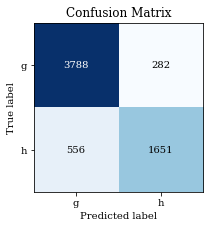

<IPython.core.display.Javascript object>

In [18]:
best_hyperparams = np.load("models/best_hyperparams_nn.npy")
best_batch_nn = best_hyperparams[0]
best_dropout_1 = best_hyperparams[1]
best_dropout_2 = best_hyperparams[2]
best_nodes_1 = best_hyperparams[3]
best_nodes_2 = best_hyperparams[4]

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Dense(best_nodes_1, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_1),
        tf.keras.layers.Dense(best_nodes_2, activation="relu"),
        tf.keras.layers.Dropout(best_dropout_2),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
model.compile(
    optimizer="adam", loss="categorical_crossentropy",
)
model.load_weights("models/best_nn_not_pca")

y_pred_train_nn = model.predict_classes(X_train.to_numpy()).reshape(-1, 1)
y_pred_train_nn = np.append(y_pred_train_nn == 0, y_pred_train_nn == 1, axis=1).astype(
    np.int
)

y_pred_test_nn = model.predict_classes(X_test.to_numpy()).reshape(-1, 1)
y_pred_test_nn = np.append(y_pred_test_nn == 0, y_pred_test_nn == 1, axis=1).astype(
    np.int
)

f1_score_weighted_train = sklme.f1_score(
    y_true=y_train, y_pred=y_pred_train_nn, average="weighted"
)

f1_score_weighted_test = sklme.f1_score(
    y_true=y_test, y_pred=y_pred_test_nn, average="weighted"
)


print("Neural Network:")
print(f"Train weighted f1 score: {f1_score_weighted_train:.2f}")
print(f"Test weighted f1 score: {f1_score_weighted_test:.2f}")
print(f"Best hyperparams: {best_hyperparams}")

fig, ax = plt.subplots(figsize=[3.01682, 3.01682])
sklplt.metrics.plot_confusion_matrix(
    encoder.inverse_transform(y_test.to_numpy()),
    encoder.inverse_transform(y_pred_test_nn),
    ax=ax,
)
ax.set_ylim([1.5, -0.5])
ax.set_xlim([-0.5, 1.5])
im = ax.images
cb = im[-1].colorbar
cb.remove()
fig.tight_layout()
fig.savefig("doc/figures/nn_confusion_matrix.pdf", dpi=1000)
plt.show()

# XGBoost

In [ ]:
y_train_split_boost = encoder.inverse_transform(y_train_split).ravel()
y_validation_boost = encoder.inverse_transform(y_validation).ravel()


validation_set_boost = [(X_validation, y_validation_boost)]

xgboost = xgb.XGBClassifier(
    objective="binary:logistic",
    n_jobs=-1,
    n_estimators=400,
    max_depth=3,
    reg_lambda=0,
    reg_alpha=0,
).fit(
    X=X_train_split,
    y=y_train_split_boost,
    eval_metric=["logloss"],
    eval_set=validation_set_boost,
    early_stopping_rounds=3,
    verbose=False,
)

In [ ]:
y_pred_train_boost = xgboost.predict(X_train.to_numpy()).reshape(-1, 1)
y_pred_test_boost = xgboost.predict(X_test.to_numpy()).reshape(-1, 1)

f1_score_weighted_train_boost = sklme.f1_score(
    y_true=y_train, y_pred=encoder.transform(y_pred_train_boost), average="weighted"
)

f1_score_weighted_test_boost = sklme.f1_score(
    y_true=y_test, y_pred=encoder.transform(y_pred_test_boost), average="weighted"
)

print("XGBoost:")
print(f"Train weighted f1 score: {f1_score_weighted_train_boost:.2f}")
print(f"Test weighted f1 score: {f1_score_weighted_test_boost:.2f}")


fig, ax = plt.subplots(figsize=[3.01682, 3.01682])
sklplt.metrics.plot_confusion_matrix(
    encoder.inverse_transform(y_test.to_numpy()), y_pred_test_boost, ax=ax,
)

ax.set_ylim([1.5, -0.5])
ax.set_xlim([-0.5, 1.5])
im = ax.images
cb = im[-1].colorbar
cb.remove()
fig.tight_layout()
fig.savefig("doc/figures/xgboost_confusion_matrix.pdf", dpi=1000)
plt.show()

In [ ]:
pca = sklde.PCA(n_components="mle")
X_train_pca = pd.DataFrame(pca.fit_transform(X_train))
X_test_pca = pd.DataFrame(pca.transform(X_test))
fig, ax = plt.subplots(figsize=(10 * 1.618, 10))
sns.heatmap(
    X_train_pca.corr(), cmap="YlGnBu", ax=ax, square=True, annot=True, cbar=False
)
ax.set_ylim([9, 0])
ax.set_xlim([0, 9])
fig.tight_layout()
plt.show()